In [ ]:
##### Fig. 3 - Phonemic and prosodic representations in ventral and dorsal stream regions
#
# written by S-C. Baek
# updated date: 16.12.2024
#

In [1]:
# import packages
import os
import sys
import pickle

import numpy as np

from mne.stats.multi_comp import fdr_correction

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# path settings
FIGDIR  = os.getcwd()
MAINDIR = os.path.abspath('..')
DATADIR = MAINDIR + os.sep + 'data/'
PYDIR   = MAINDIR + os.sep + 'code' + os.sep + 'python/'

In [3]:
# add path to PYDIR to import functions
if PYDIR not in sys.path:
    sys.path.insert(1, PYDIR)
from utils import fisher_z_transform

In [4]:
# subjects
s = os.listdir(DATADIR)
subjects = [i for i in s if 'sub-' in i]
subjects.sort()
n_subjects = len(subjects)

In [5]:
# linguistic elements
elements = ['phoneme', 'prosody']
n_elements = len(elements)

In [6]:
 # colors
cmap = matplotlib.colormaps['tab10']
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_indices = np.array([9, 6, 2, 1, 4])
colors = np.array(colors)[color_indices]

In [ ]:
# Fig. 3a,b - general representations of phonemes or prosody in 10 ROIs

In [7]:
# elements to plot
ei = 0 # 0: phonemes, 1: prosody
element = elements[ei]

# onset of relevant acoustic landmarks and stimulus offset
tonoff = np.zeros( (2,2) )
if element == 'phoneme':
    tonoff[0,:] = np.array([0.026, 0.062]) # voicing, in s
else:
    tonoff[0,:] = np.array([0.184, 0.250]) # pitch divergence, in s
tonoff[1,:] = np.array([0.464, 0.500]) # offset, in s

In [8]:
# get data configuration
fname = DATADIR + subjects[0] + os.sep + 'meg' + os.sep +\
        'rsa_rois_' + element + '_gen.pickle'
with open(fname, 'rb') as f:
    tmp = pickle.load(f)
n_rois, n_times = tmp['rsa_vals'].shape
    
# reconstrunct time info.
tmin  = tmp['tmin']
tstep = tmp['tstep']
tmax  = tmin + tstep*(n_times-1)
times = np.linspace(tmin, tmax, n_times)

# ROI labels for plotting
rois = np.array(tmp['labels'])
del fname, tmp

In [9]:
# import data
X = np.zeros( (n_rois, n_times, n_subjects) ) # init a matrix

# loop over subjects
for subi, subject in enumerate(subjects):
    
    # import individual data
    fname = DATADIR + subject + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_gen.pickle' # general represent.
    with open(fname, 'rb') as f:
        rsa_rois = pickle.load(f)
    X[:,:,subi] = rsa_rois['rsa_vals']
    del fname, rsa_rois
    
# apply Fisher Z transformation to R^2 after taking sqrt of it
X = fisher_z_transform(X, sqrt=True)

# apply baseline correction to the data
t0Idx = np.argmin(np.abs(times)) # onset index
Z = X - np.mean(X[:, :t0Idx, :], axis=1)[:, np.newaxis, :] # baseline correction

In [10]:
 # import ROI-wise cluster statistics
fname = DATADIR + 'group' + os.sep + 'meg' + os.sep + 'rsa_rois_' + element + '_gen_vs_baseline_p05.pickle'
with open(fname, 'rb') as f:
    cluster_stats_rois = pickle.load(f)

In [11]:
# FDR correction based on the minimum p-value of each ROI
pvals = list()
for cluster_stats in cluster_stats_rois:
    if len(cluster_stats[1]) > 0:
        pvals.append(np.min(cluster_stats[1]))
    else:
        pvals.append(0.99)
reject, pvals_correct = fdr_correction(pvals) # apply FDR correction
factor = pvals_correct / pvals

# getting sigificant clusters after the correction
sig_clusters = list()
sig_clusters_pval = list()
for i, stat in enumerate(cluster_stats_rois):
    if reject[i]:
        # points consisting of a cluster
        sig_ids = np.where(stat[1] * factor[i] < 0.05)[0] # identifying the indices of significant clusters
        sig_pnts = [stat[0][idx] for idx in sig_ids] 
        sig_clusters.append(sig_pnts)
        
        # cluster-wise p-valse 
        sig_pvals = [stat[1][idx] for idx in sig_ids]
        sig_clusters_pval.append(sig_pvals)
    else:
        # points consisting of a cluster
        sig_pnts = [] 
        sig_clusters.append(sig_pnts)
        
        # cluster-wise p-valse 
        sig_pvals = []
        sig_clusters_pval.append(sig_pvals)
    
# group cluster extents and p-values
sig_clusters_rois = (sig_clusters, sig_clusters_pval)

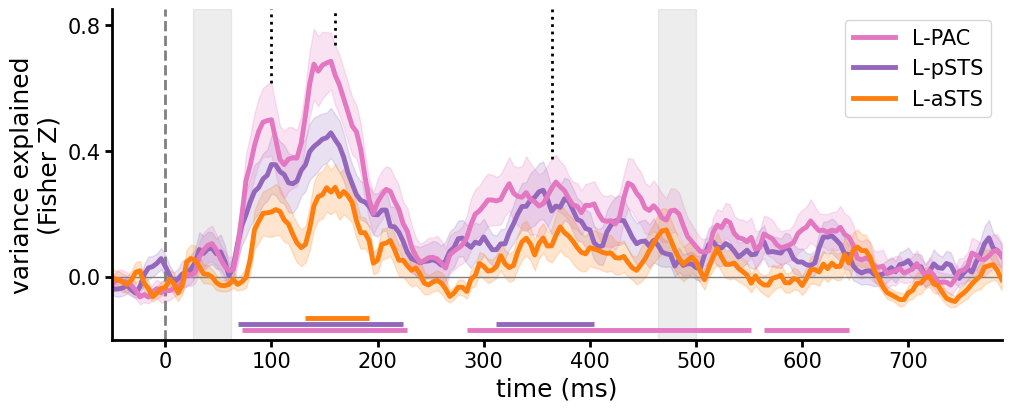

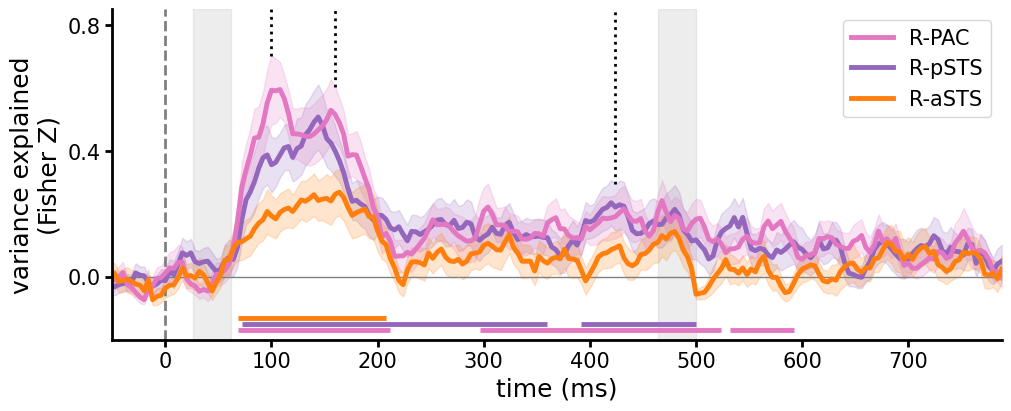

In [12]:
# group-level data for plotting
m     = np.mean(Z, axis=-1) # mean
sem   = np.std(Z, axis=-1) / np.sqrt(n_subjects) # sem
upper = m + sem
lower = m - sem

# range of x- & y-axis
xlim  = (-50, times[-1]*1e3)
x0Idx = np.argmin(np.abs(times - xlim[0]*1e-3))
ylim  = (-0.20, 0.85) if element == 'phoneme' else (-0.20, 0.65)
    
# time stamp to mark (for comparison with searchlight RSA)
if element == 'phoneme':
    tstamps = np.array([[0.100, 0.160, 0.364],
                       [0.100, 0.160, 0.424]])
else:
    tstamps = np.array([[0.412, 0.460, 0.484],
                       [0.400, 0.496, 0.568]])

# loop over hemispheres
for hemi in ['L', 'R']:
    
    # rois in each hemisphere
    roi_inds = [ri for ri, roi in enumerate(rois) if hemi in roi]
    roi_inds = np.array(roi_inds)
    
    # figure
    fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
    
    # accessories first
    ax.vlines(0, ylim[0], ylim[1], linewidth=2.0, linestyle='--', color=np.ones(3)*0.5) # stimulus onset
    ax.hlines(0, xlim[0], xlim[1], linewidth=1.0, color=np.ones(3)*0.5) 
    ax.fill_between(tonoff[0,:]*1e3, np.ones(2)*ylim[0], np.ones(2)*ylim[1], 
                    color='#A9A9A9', alpha=0.2) # acoustic landmark
    ax.fill_between(tonoff[1,:]*1e3, np.ones(2)*ylim[0], np.ones(2)*ylim[1], 
                    color='#A9A9A9', alpha=0.2) # stimulus offset
    
    # plot RSA results
    porder = np.array([4,1,3,0,2]) # plotting order of regions
    mask  = np.zeros(len(roi_inds), dtype=bool)
    for roii in roi_inds[porder]:
        if sig_clusters_rois[0][roii]: # plotting only significant ROIs
            mask[roii%5]=True # to record significant ROIs for legend
            # mean & s.e.m
            ax.plot(1e3*times[x0Idx:], m[roii,x0Idx:], color=colors[roii%5], linewidth=3.5, label=rois[roii])
            ax.fill_between(1e3*times[x0Idx:], upper[roii,x0Idx:], lower[roii,x0Idx:], 
                            color=colors[roii%5], alpha=0.2)
            
    # mark significant interval 
    y_pos = -0.09
    iorder = np.array([0,2,3,4,1])
    for roii in roi_inds[iorder]:
        sig_points = sig_clusters_rois[0][roii] # cluster extents in samples
        for pnt in sig_points:
            ax.hlines(y_pos, times[t0Idx+pnt[0][0]]*1e3, times[t0Idx+pnt[0][-1]]*1e3,
                      color=colors[roii % 5], linewidth=3.5)
        y_pos -= 0.02
    
    # plot time stamps
    ts = tstamps[0] if hemi == 'L' else tstamps[1]
    for t in ts:
        ti = np.argmin(np.abs(times-t))
        ax.vlines(t*1e3, max(upper[roi_inds,ti]), ylim[1], linewidth=2.0, linestyle='dotted', color='k')
    
    # for reordering legend
    lorder = np.array([0, 2, 1, 4, 3])
    orig_order = np.argsort(roi_inds[porder][mask[porder]])
    new_order = np.argsort(roi_inds[lorder][mask[lorder]])
    
    # accessories
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(np.array(handles)[orig_order][new_order], np.array(labels)[orig_order][new_order], 
              loc='upper right', fontsize=15)
    roi_inds[lorder][mask[lorder]]
    ax.set_xlim(xlim[0], xlim[-1])
    ax.set_xlabel('time (ms)', fontsize=18)
    ax.set_ylim(ylim[0], ylim[-1]) # fixed range
    ax.set_ylabel('variance explained\n(Fisher Z)', fontsize=18)
    ax.set_yticks([0, 0.4, 0.8]) if element == 'phoneme' else ax.set_yticks([0, 0.3, 0.6])        
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.xaxis.set_tick_params(length=5, width=2)
    ax.yaxis.set_tick_params(length=5, width=2)